In [75]:
# https://github.com/utd-ai/Data_Mining_in_Action_2018_Spring/blob/master/trends/data_2/CapsuleNetwork_HW.ipynb
#https://github.com/higgsfield/Capsule-Network-Tutorial/blob/master/Capsule%20Network.ipynb

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import datasets, transforms

# have no cuda :(
USE_CUDA = False

**Load Dataset**


In [52]:
#load MNIST dataset
class Mnist:
    def __init__(self, batch_size):
        dataset_transform = transforms.Compose([
            transforms.ToTensor(), #convert image to PyTorch tensor
            transforms.Normalize((0.01307,),(0.3081,)) #normalize tensor with values provided by PyTorch
        ]) 
    
        training_data = datasets.MNIST('./data/mnist', train = True, transform = dataset_transform, 
                                          download = True )
        test_data = datasets.MNIST('./data/mnist', train = False,  transform = dataset_transform, 
                                      download = True )
        
        #batching and shuffeling data
        self.train_loader  = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
        self.test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [53]:
#load MNIST dataset
class FashionMnist:
    def __init__(self, batch_size):
        dataset_transform = transforms.Compose([
            transforms.ToTensor(), #convert image to PyTorch tensor
            transforms.Normalize((0.01307,),(0.3081,)) #normalize tensor with values provided by PyTorch
        ]) 
        # self only for visualization
        self.training_data = datasets.FashionMNIST('./data/fashionmnist', train = True, transform = dataset_transform, 
                                          download = True )
        self.test_data = datasets.FashionMNIST('./data/fashionmnist', train = False,  transform = dataset_transform, 
                                      download = True )
        
        #batching and shuffeling data
        self.train_loader  = torch.utils.data.DataLoader(self.training_data, batch_size=batch_size, shuffle=True)
        self.test_loader  = torch.utils.data.DataLoader(self.test_data, batch_size=batch_size, shuffle=True)
        

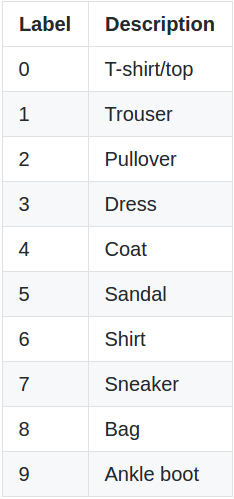

### Convolutional Layer

In [54]:
#Convolutional Layer, extracting basic features
#param taken from paper
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel_size,
                               stride=1
                             )

    def forward(self, x):
        return F.relu(self.conv(x))

### First Capsule Layer

In [55]:
class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels = 32,
                kernel_size=9):
        super(PrimaryCaps, self).__init__()
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                     kernel_size=kernel_size, stride =2,padding=0)
            for _ in range(num_capsules)
        ])
        
    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        u = u.view(x.size(0), 32 * 6 * 6, -1)
        return self.squash(u)
    
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

In [56]:
class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W, x)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        if USE_CUDA:
            b_ij = b_ij.cuda()

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = self.squash(s_j)
            
            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)
    
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

In [57]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.reconstruction_layers = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes)
        
        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.sparse.torch.eye(10))
        if USE_CUDA:
            masked = masked.cuda()
        masked = masked.index_select(dim=0, index=max_length_indices.squeeze(1).data)
        
        reconstructions = self.reconstruction_layers((x * masked[:, :, None, None]).view(x.size(0), -1))
        reconstructions = reconstructions.view(-1, 1, 28, 28)
        
        return reconstructions, masked


In [58]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()
        
        self.mse_loss = nn.MSELoss()
        
    def forward(self, data):
        output = self.digit_capsules(self.primary_capsules(self.conv_layer(data)))
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked
    
    def loss(self, data, x, target, reconstructions):
        return self.margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)
    
    def margin_loss(self, x, labels, size_average=True):
        batch_size = x.size(0)

        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)

        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss
    
    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.0005

TypeError: Invalid shape (1, 28, 28) for image data

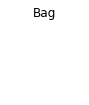

In [59]:
batch_size = 100
mnist = FashionMnist(batch_size)


labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

fig = plt.figure(figsize=(8,8));
columns = 4;

rows = 5;

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(mnist.training_data));
    img = mnist.training_data[img_xy][0]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[mnist.training_data[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [60]:
type(fmnist.training_data[1][0])

PIL.Image.Image

In [61]:
capsule_net = CapsNet()
if USE_CUDA:
    capsule_net = capsule_net.cuda()
    
optimizer = Adam(capsule_net.parameters())



In [66]:
n_epochs = 1
batch_size = 100
mnist = FashionMnist(batch_size)

for epoch in range(n_epochs):
    capsule_net.train()
    train_loss = 0
    for batch_id, (data, target) in enumerate(mnist.train_loader):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)
        loss.backward()
        optimizer.step()

        train_loss += loss.data
        
        if batch_id % 100 == 0:
            print ("train accuracy:", sum(np.argmax(masked.data.cpu().numpy(), 1) == 
                                   np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size))
        
    print (train_loss / len(mnist.train_loader))
        
    capsule_net.eval()
    test_loss = 0
    for batch_id, (data, target) in enumerate(mnist.test_loader):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)

        test_loss += loss.data
        
        if batch_id % 100 == 0:
            print ("test accuracy:", sum(np.argmax(masked.data.cpu().numpy(), 1) == 
                                   np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size))
    
    print (test_loss / len(mnist.test_loader))



/home/cbu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/cbu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


train accuracy: 0.91
train accuracy: 0.88
train accuracy: 0.94
train accuracy: 0.82
train accuracy: 0.91
train accuracy: 0.84
tensor(0.1518)
test accuracy: 0.88
tensor(0.1673)


In [83]:
# store weights & bias
torch.save(capsule_net.state_dict(), "./model_data/fmnist_1.pt")

print("Model's state_dict:")
for param_tensor in capsule_net.state_dict():
    print(param_tensor, "\t", capsule_net.state_dict()[param_tensor].size())

Model's state_dict:
conv_layer.conv.weight 	 torch.Size([256, 1, 9, 9])
conv_layer.conv.bias 	 torch.Size([256])
primary_capsules.capsules.0.weight 	 torch.Size([32, 256, 9, 9])
primary_capsules.capsules.0.bias 	 torch.Size([32])
primary_capsules.capsules.1.weight 	 torch.Size([32, 256, 9, 9])
primary_capsules.capsules.1.bias 	 torch.Size([32])
primary_capsules.capsules.2.weight 	 torch.Size([32, 256, 9, 9])
primary_capsules.capsules.2.bias 	 torch.Size([32])
primary_capsules.capsules.3.weight 	 torch.Size([32, 256, 9, 9])
primary_capsules.capsules.3.bias 	 torch.Size([32])
primary_capsules.capsules.4.weight 	 torch.Size([32, 256, 9, 9])
primary_capsules.capsules.4.bias 	 torch.Size([32])
primary_capsules.capsules.5.weight 	 torch.Size([32, 256, 9, 9])
primary_capsules.capsules.5.bias 	 torch.Size([32])
primary_capsules.capsules.6.weight 	 torch.Size([32, 256, 9, 9])
primary_capsules.capsules.6.bias 	 torch.Size([32])
primary_capsules.capsules.7.weight 	 torch.Size([32, 256, 9, 9])
pri

In [73]:
def plot_images_separately(images):
    "Plot the six MNIST images separately."
    fig = plt.figure()
    for j in range(1, 7):
        ax = fig.add_subplot(1, 6, j)
        ax.matshow(images[j-1], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

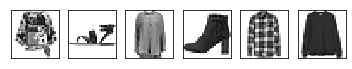

In [76]:
plot_images_separately(data[:6,0].data.cpu().numpy())

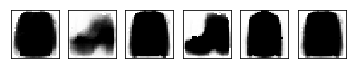

In [77]:
plot_images_separately(reconstructions[:6,0].data.cpu().numpy())

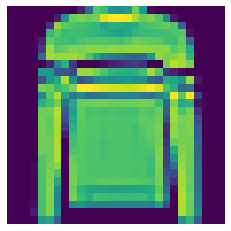

In [79]:
image, target = mnist.training_data[5]
image = image.reshape(28,28)
plt.axis("off")
plt.imshow(image)